# Compare Activity to Naturalness

First we consider the DMS datasets used by EvolvePro. Note that the "preprocessed" files are what we want, even though they have inconsistent column names...

In [1]:
ls /Users/jacobroberts/git/EvolvePro/data/dms/activity/

DMS_AsCas12f.xlsx                   all_samples_raw_data--sarscov2.csv
DMS_AsCas12f_preprocessed.xlsx      jvi.01291-19-sd003.xlsx
Source.xlsx                         sarscov2_preprocessed.csv
Zikv_E.xlsx                         zikv_E_preprocessed.xlsx
abf8761_markin_data-s1.csv


In [183]:
!cat /Users/jacobroberts/git/EvolvePro/data/dms/wt_fasta/stiffler_WT.fasta

>sp|P62593|BLAT_ECOLX Beta-lactamase TEM OS=Escherichia coli OX=562 GN=bla PE=1 SV=1
MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRP
EERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVREL
CSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTM
PAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGS
RGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW

In [187]:
tem1_str = ''.join("""MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRP
EERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVREL
CSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTM
PAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGS
RGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW""".split('\n'))
len(tem1_str)

286

In [161]:
pd.read_excel('notebooks/data/tem1_activity.xlsx', sheet_name='simplified')

,Mutation,activity_at_0,activity_at_39,activity_at_156,activity_at_625,activity_at_2500
0,H26A,0.014913,-0.001125,-0.015539,0.008340,-0.015196
1,H26C,0.022702,0.068359,-0.041813,0.021115,-0.265924
2,H26D,0.042301,0.022088,0.006506,0.028531,-0.116681
3,H26E,0.011387,0.024255,-0.029579,-0.002251,-0.196402
4,H26F,0.020599,0.042231,-0.031884,0.013892,-0.575924
...,...,...,...,...,...,...
4992,W290R,-0.025877,-0.033274,-0.690253,-1.184847,-2.417662
4993,W290S,-0.035006,-0.129397,-0.861989,-1.663356,-2.939082
4994,W290T,-0.072449,-0.151857,-0.811421,-1.617142,-2.580900
4995,W290V,-0.015917,-0.036422,-0.700273,-1.219941,-2.455181


In [3]:
import pandas as pd
import re

zika_activity = pd.read_excel('/Users/jacobroberts/git/EvolvePro/data/dms/activity/zikv_E_preprocessed.xlsx')
zika_activity = zika_activity.rename(columns={'variant': 'seq_id', 'effect': 'activity'})[['seq_id', 'activity']]

cas_activity = pd.read_excel('/Users/jacobroberts/git/EvolvePro/data/dms/activity/DMS_AsCas12f_preprocessed.xlsx')
cas_activity = cas_activity.rename(columns={'variant': 'seq_id', 'avg_activity': 'activity'})[['seq_id', 'activity']]

rubisco_activity = pd.read_csv('notebooks/data/rubisco_activity.csv')
rubisco_activity = rubisco_activity.rename(columns={'mutant': 'seq_id', 'Fitness': 'activity'})[['seq_id', 'activity']]

tem1_activity = pd.read_excel('notebooks/data/tem1_activity.xlsx', sheet_name='simplified')
tem1_activity = tem1_activity.rename(columns={'Mutation': 'seq_id', 'activity_at_2500': 'activity'})[['seq_id', 'activity']]
def fix_tem1_seq_id(seq_id):
  m = re.match(r'([A-Z])(\d+)(.*)', seq_id)
  assert m, seq_id
  old_id = m.groups()[0]
  locus = int(m.groups()[1])
  new_id = m.groups()[2]

  new_locus = locus - 2
  
  if new_locus >= 245:
    new_locus = new_locus - 2

  return f'{old_id}{new_locus}{new_id}'
tem1_activity['seq_id'] = tem1_activity.seq_id.apply(fix_tem1_seq_id)


In [241]:
import re

def load_naturalness_df(naturalness_csv):
  naturalness_df = pd.read_csv(naturalness_csv)

  def seq_id_to_locus(seq_id):
      return int(re.match(r'.(\d+).*', seq_id).group(1))  
  naturalness_df['locus'] = naturalness_df.seq_id.apply(seq_id_to_locus)

  wt_naturalness = naturalness_df[naturalness_df.seq_id.apply(lambda x: x[0] == x[-1])].rename(columns={'probability': 'wt_probability'}).drop(columns=['seq_id'])

  naturalness_df = pd.merge(naturalness_df, wt_naturalness, left_on='locus', right_on='locus', how='left')
  naturalness_df['wt_marginal'] = naturalness_df.apply(lambda x: x.probability / x.wt_probability, axis=1)
  return naturalness_df

zika_naturalness = load_naturalness_df('notebooks/data/logits_zika_wt_melted.csv')
cas_naturalness = load_naturalness_df('notebooks/data/logits_AsCas12f_wt_melted.csv')
rubisco_naturalness = load_naturalness_df('notebooks/data/logits_rubisco_wt_melted.csv')
tem1_naturalness = load_naturalness_df('notebooks/data/logits_tem1_wt_melted.csv')


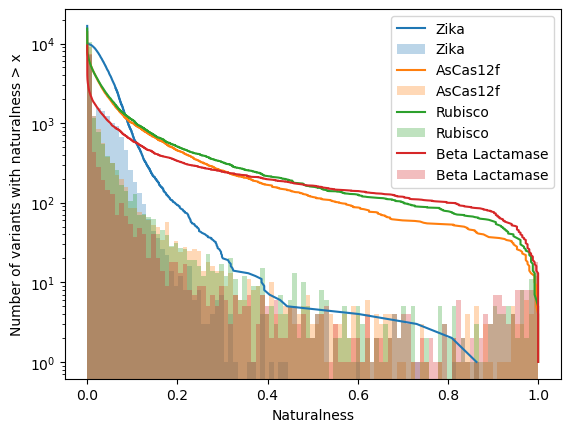

In [257]:
# Plot "number of variants with naturalness > x"
def plot_naturalness_cdf(naturalness_df, label):
    sorted_naturalness = naturalness_df.sort_values('probability', ascending=True)
    plt.plot(sorted_naturalness.probability, np.arange(len(sorted_naturalness), 0, -1), label=label)

    # Also plot the PDF as a histogram with 100 bins spaced from 0 to 1 with alpha=0.3.
    # The colors of the histogram should match the colors of the line plot.
    plt.hist(sorted_naturalness.probability, bins=np.linspace(0, 1, 100), alpha=0.3, label=label, color=plt.gca().lines[-1].get_color())

plot_naturalness_cdf(zika_naturalness, 'Zika')
plot_naturalness_cdf(cas_naturalness, 'AsCas12f')
plot_naturalness_cdf(rubisco_naturalness, 'Rubisco')
plot_naturalness_cdf(tem1_naturalness, 'Beta Lactamase')

plt.yscale('log')
plt.xlabel('Naturalness')
plt.ylabel('Number of variants with naturalness > x')
plt.legend()

In [338]:
zika_activity.merge(zika_naturalness, on='seq_id').sort_values('activity', ascending=False).head(50)

,seq_id,activity,probability,locus,wt_probability,wt_marginal
6525,Q344K,8.439089,0.079590,344,0.042480,1.873563
3681,T194R,8.319306,0.043945,194,0.056396,0.779221
3675,T194K,8.184864,0.063965,194,0.056396,1.134199
6720,P354R,6.654798,0.044189,354,0.082520,0.535503
6638,Q350I,6.422287,0.019775,350,0.032715,0.604478
5973,T315I,6.386942,0.014832,315,0.075195,0.197240
3027,T160H,5.746267,0.029907,160,0.071777,0.416667
6675,L352H,5.692353,0.022827,352,0.090332,0.252703
6618,M349H,5.430333,0.013794,349,0.037354,0.369281
6623,M349P,5.164739,0.130859,349,0.037354,3.503268


Text(0.02, 0.5, 'Enrichment (# high activity / # expected)')

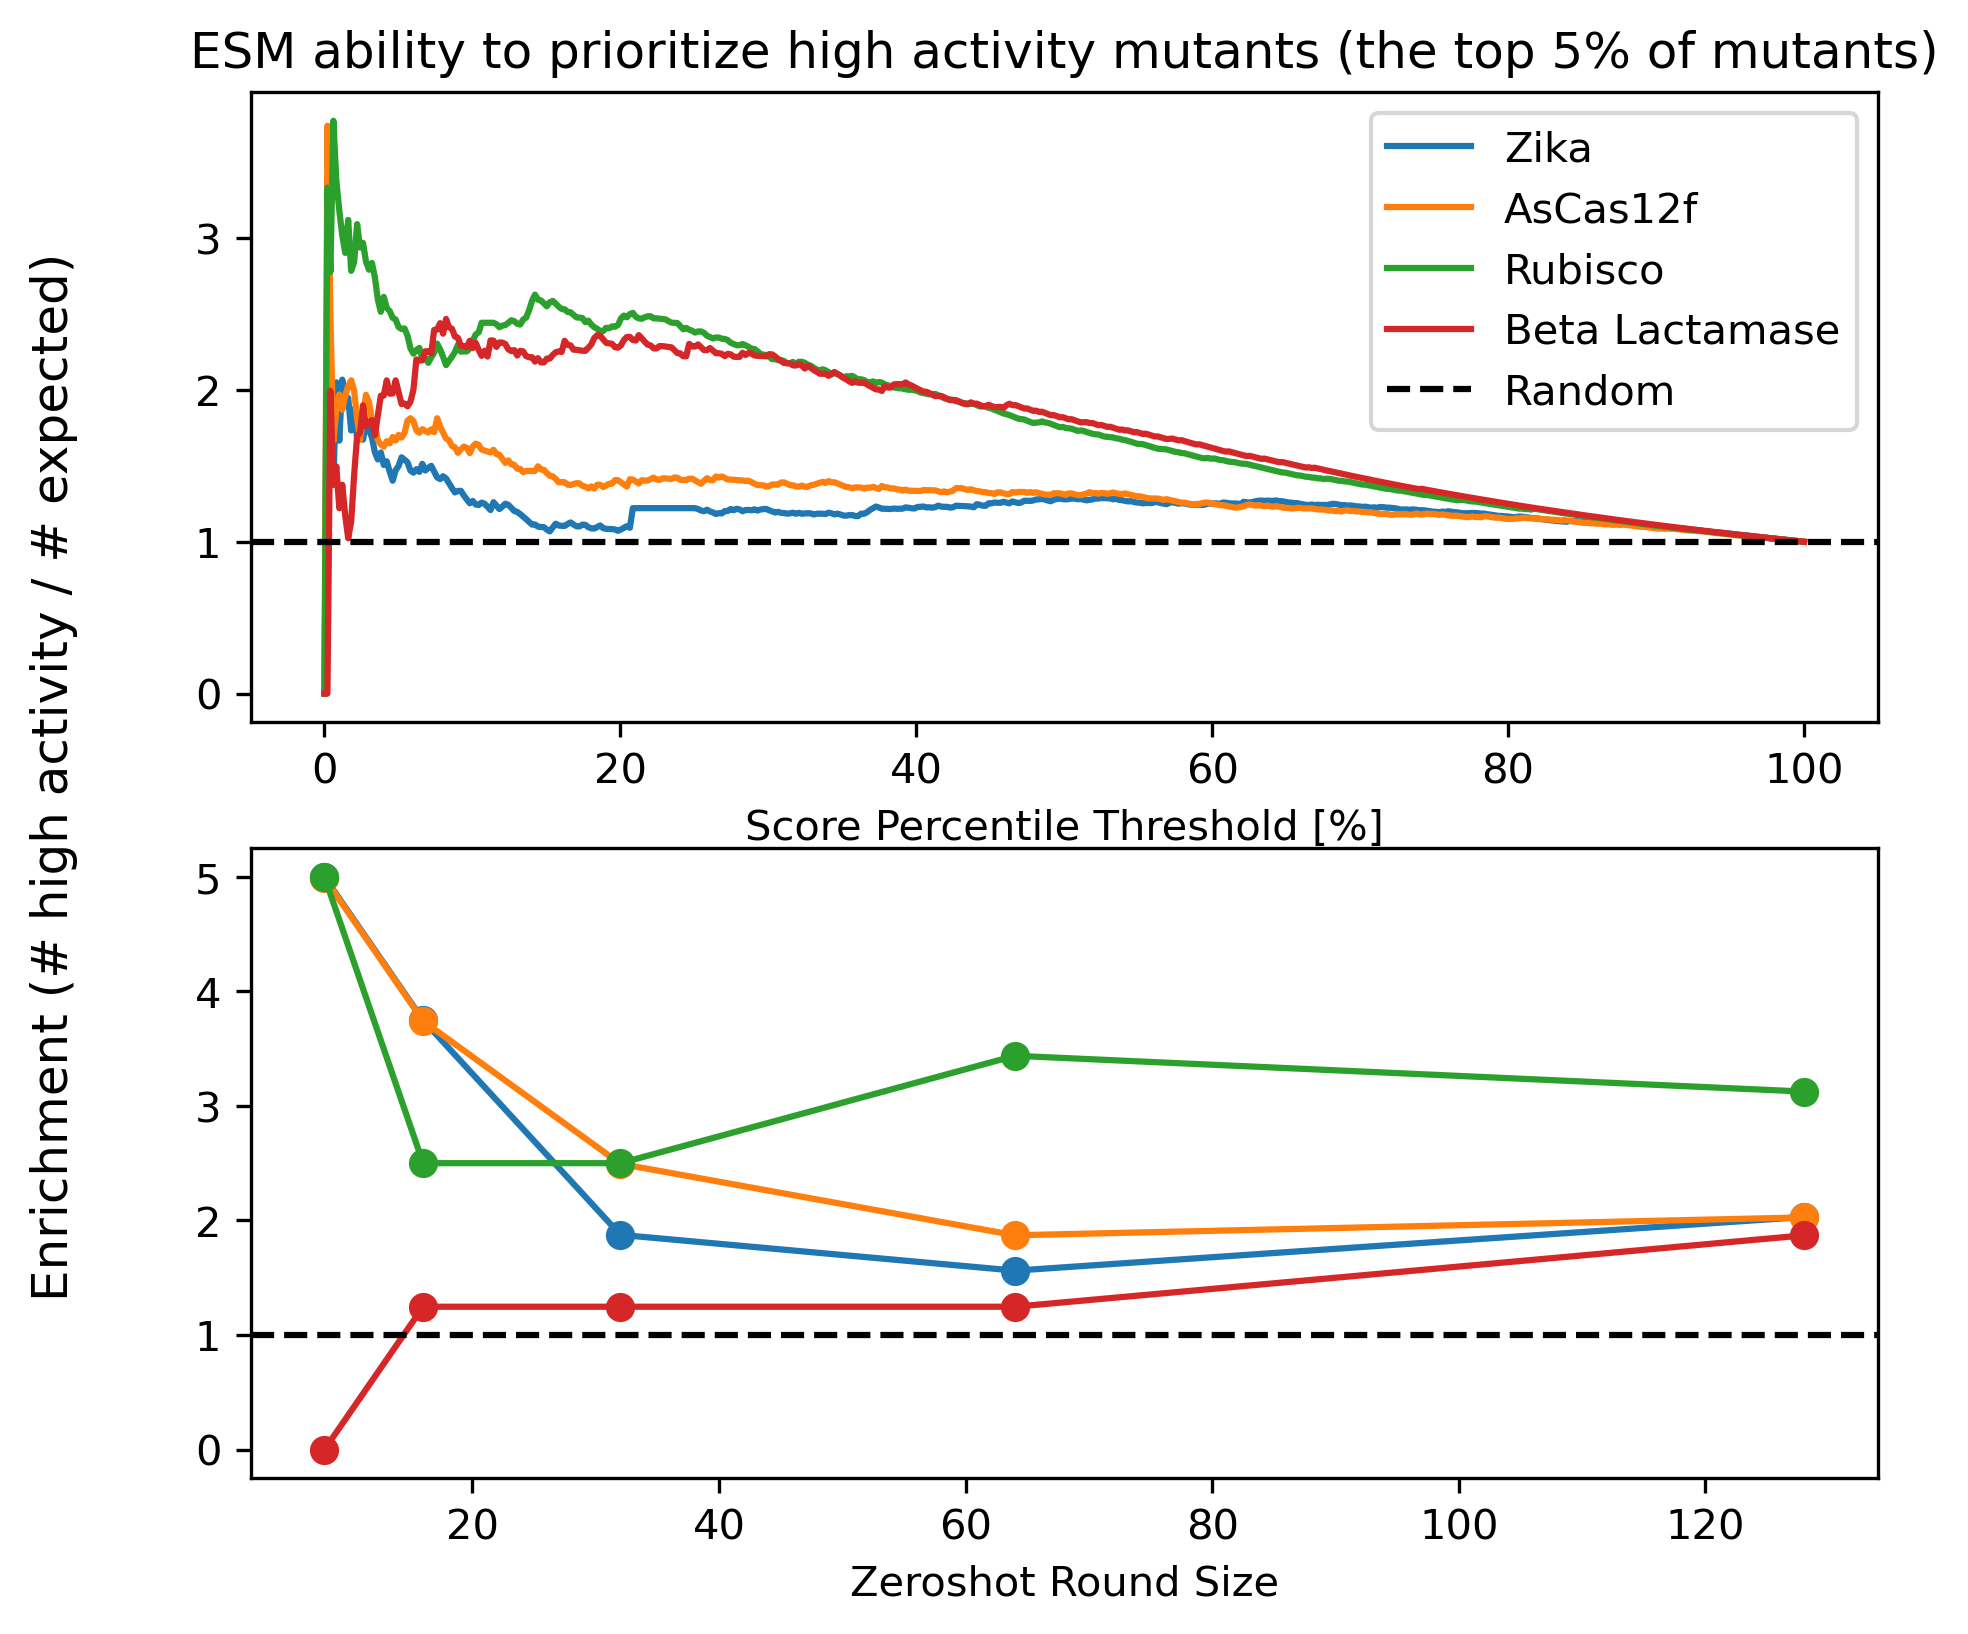

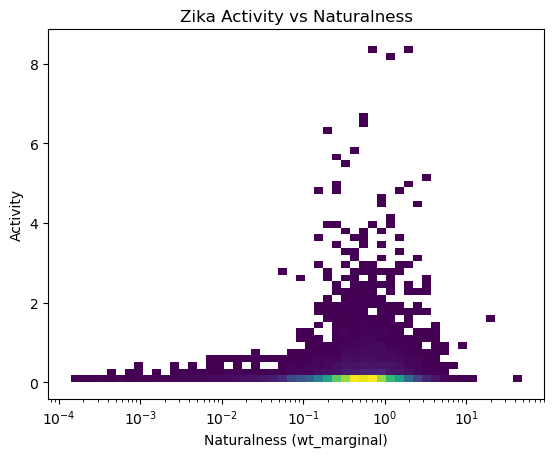

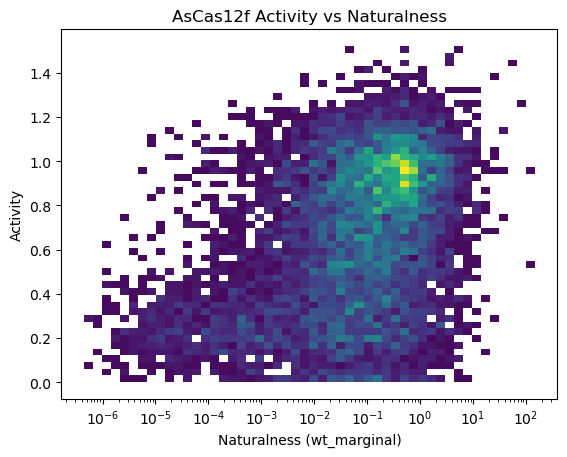

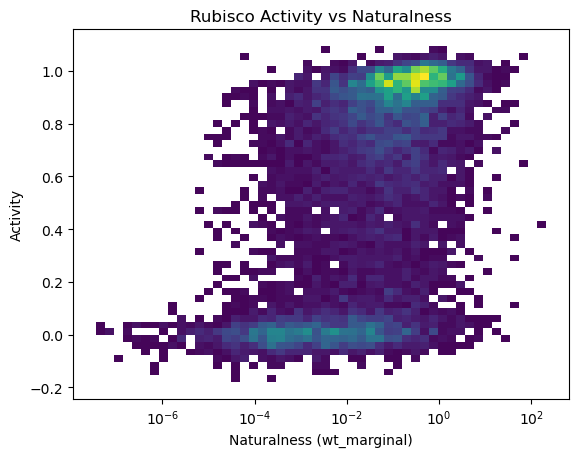

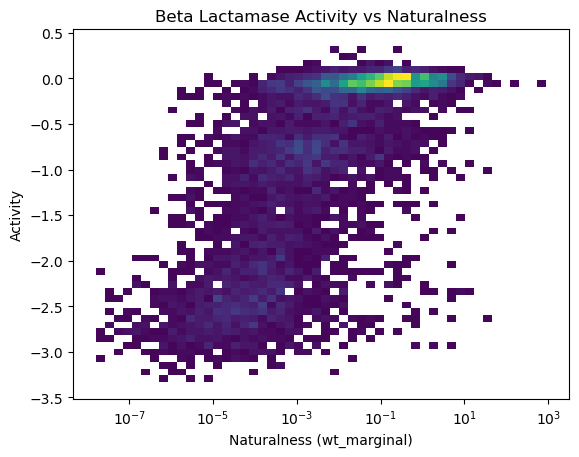

In [335]:
TOP_PERCENTILE = 5

SCORING_METRIC = 'wt_marginal'

def calculate_enrichment_quantiles(df, score_col, activity_col='activity'):
    # Calculate threshold for top X% of activity
    activity_threshold = df[activity_col].quantile(1 - TOP_PERCENTILE/100)
    
    # Calculate enrichment at different score thresholds
    score_percentiles = np.linspace(0, 100, 500)
    enrichments = []
    
    for p in score_percentiles:
        score_threshold = df[score_col].quantile(1 - p/100)
        
        # Calculate enrichment
        high_activity_rate_in_selection = (df[df[score_col] >= score_threshold][activity_col] >= activity_threshold).mean()
        baseline_rate = (df[activity_col] >= activity_threshold).mean()
        enrichment = high_activity_rate_in_selection / baseline_rate
        
        enrichments.append({
          'percentile': p,
          'score_threshold': score_threshold,
          'num_variants_in_selection': (df[score_col] >= score_threshold).sum(),
          'high_activity_rate_in_selection': high_activity_rate_in_selection,
          'baseline_rate': baseline_rate,
          'enrichment': enrichment,
          })
    
    return pd.DataFrame(enrichments)

def calculate_enrichment_zeroshot(df, score_col, activity_col='activity'):
    # Calculate threshold for top X% of activity
    activity_threshold = df[activity_col].quantile(1 - TOP_PERCENTILE/100)
    
    # Calculate enrichment at different score thresholds
    zeroshot_round_sizes = [8, 16, 32, 64, 128]
    enrichments = []
    
    for zeroshot_round_size in zeroshot_round_sizes:
        # Calculate enrichment
        high_activity_rate_in_selection = (df.sort_values(score_col, ascending=False).iloc[:zeroshot_round_size][activity_col] >= activity_threshold).mean()
        baseline_rate = (df[activity_col] >= activity_threshold).mean()
        enrichment = high_activity_rate_in_selection / baseline_rate
        
        enrichments.append({
          'zeroshot_round_size': zeroshot_round_size,
          'high_activity_rate_in_selection': high_activity_rate_in_selection,
          'baseline_rate': baseline_rate,
          'enrichment': enrichment,
        })
    
    return pd.DataFrame(enrichments)

# Dig into relationship.
def plot_relationship_between_naturalness_and_activity(df, enrichment_quantiles_ax, enrichment_zeroshot_ax, label):
  enrichment_quantiles_df = calculate_enrichment_quantiles(df, score_col=SCORING_METRIC)
  # enrichment_df = calculate_enrichment(df, score_col='probability')
  enrichment_quantiles_ax.plot(enrichment_quantiles_df.percentile, enrichment_quantiles_df.enrichment, label=label)

  enrichment_zeroshot_df = calculate_enrichment_zeroshot(df, score_col=SCORING_METRIC)
  # enrichment_df = calculate_enrichment(df, score_col='probability')
  enrichment_zeroshot_ax.plot(enrichment_zeroshot_df.zeroshot_round_size, enrichment_zeroshot_df.enrichment, label=label, marker='o')
  plt.figure()
  plt.title(f'{label} Activity vs Naturalness')
  plt.xlabel(f'Naturalness ({SCORING_METRIC})')
  plt.ylabel('Activity')
  sns.histplot(data=df, x=SCORING_METRIC, y='activity', bins=50, log_scale=(True, False), cmap='viridis')

fig, [enrichment_quantiles_ax, enrichment_zeroshot_ax] = plt.subplots(2, figsize=(7, 6), dpi=300)
plot_relationship_between_naturalness_and_activity(
  zika_activity.merge(zika_naturalness, on='seq_id'), enrichment_quantiles_ax, enrichment_zeroshot_ax, 'Zika'
)
plot_relationship_between_naturalness_and_activity(
  cas_activity.merge(cas_naturalness, on='seq_id'), enrichment_quantiles_ax, enrichment_zeroshot_ax, 'AsCas12f'
)
plot_relationship_between_naturalness_and_activity(
  rubisco_activity.merge(rubisco_naturalness, on='seq_id'), enrichment_quantiles_ax, enrichment_zeroshot_ax, 'Rubisco'
)
plot_relationship_between_naturalness_and_activity(
  tem1_activity.merge(tem1_naturalness, on='seq_id'), enrichment_quantiles_ax, enrichment_zeroshot_ax, 'Beta Lactamase'
)
enrichment_quantiles_ax.set_title(f'ESM ability to prioritize high activity mutants (the top {TOP_PERCENTILE}% of mutants)')
enrichment_quantiles_ax.axhline(1, color='black', linestyle='--', label='Random')
enrichment_quantiles_ax.set_xlabel('Score Percentile Threshold [%]')
enrichment_quantiles_ax.legend()

enrichment_zeroshot_ax.axhline(1, color='black', linestyle='--', label='Random')
enrichment_zeroshot_ax.set_xlabel('Zeroshot Round Size')
# enrichment_zeroshot_ax.set_ylabel(f'Enrichment of top {TOP_PERCENTILE}% mutants')

fig.supylabel(f'Enrichment (# high activity / # expected)')


In [318]:
df = rubisco_activity.merge(rubisco_naturalness, on='seq_id')

activity_threshold = df['activity'].quantile(1 - 5.0/100)
df['high_activity'] = df['activity'] >= activity_threshold
activity_threshold

np.float64(1.0013814759024613)

In [319]:
calculate_enrichment_zeroshot(df, 'wt_marginal')

,zeroshot_round_size,high_activity_rate_in_selection,baseline_rate,enrichment
0,8,0.250000,0.05,5.0000
1,16,0.125000,0.05,2.5000
2,32,0.125000,0.05,2.5000
3,64,0.171875,0.05,3.4375
4,128,0.156250,0.05,3.1250


In [321]:
df.sort_values('activity', ascending=False).head(50).reset_index()


,index,seq_id,activity,probability,locus,wt_probability,wt_marginal,high_activity
0,6259,E333A,1.093752,0.094238,333,0.121094,0.778226,True
1,3323,E178S,1.085234,0.001801,178,0.566406,0.003179,True
2,1729,I94T,1.083944,0.028687,94,0.034668,0.827465,True
3,6781,M360Q,1.077787,0.011536,360,0.232422,0.049632,True
4,5622,S299T,1.074428,0.050537,299,0.047363,1.067010,True
5,408,V24I,1.067919,0.324219,24,0.251953,1.286822,True
6,1491,T81V,1.061534,0.519531,81,0.006531,79.551402,True
7,3791,P203C,1.058300,0.000068,203,0.960938,0.000070,True
8,8755,L464W,1.056422,0.014404,464,0.093750,0.153646,True
9,2364,Y127W,1.055761,0.169922,127,0.169922,1.000000,True


In [320]:
df.sort_values('wt_marginal', ascending=False).head(50).reset_index()

,index,seq_id,activity,probability,locus,wt_probability,wt_marginal,high_activity
0,2087,Q113F,0.421412,0.609375,113,0.002823,215.870270,False
1,1491,T81V,1.061534,0.519531,81,0.006531,79.551402,True
2,2734,W147R,0.639568,0.320312,147,0.004578,69.973333,False
3,7532,I400P,0.808303,0.867188,400,0.015869,54.646154,False
4,2098,Q113Y,0.107518,0.144531,113,0.002823,51.200000,False
5,5935,Q315A,1.005686,0.337891,315,0.007019,48.139130,True
6,1234,D68A,0.373059,0.486328,68,0.011414,42.609626,False
7,5301,N282L,0.865717,0.209961,282,0.004944,42.469136,False
8,983,N54W,0.289976,0.726562,54,0.019287,37.670886,False
9,2676,S144D,0.957072,0.498047,144,0.014099,35.324675,False


In [299]:
tem1_naturalness[(tem1_naturalness.locus > 20)].groupby('locus').seq_id.first()

locus
21      V21<cls>
22      F22<cls>
23      A23<cls>
24      H24<cls>
25      P25<cls>
         ...    
282    L282<cls>
283    I283<cls>
284    K284<cls>
285    H285<cls>
286    W286<cls>
Name: seq_id, Length: 266, dtype: object

In [193]:
tem1_first_mut = tem1_naturalness[tem1_naturalness.seq_id.str.endswith('A')]

In [195]:
tem1_first_mut[tem1_first_mut.locus > 20]

,seq_id,probability,locus,wt_probability,wt_marginal
665,V21A,0.400391,21,0.166992,2.397661
698,F22A,0.127930,22,0.087891,1.455556
731,A23A,0.796875,23,0.796875,1.000000
764,H24A,0.200195,24,0.200195,1.000000
797,P25A,0.605469,25,0.036377,16.644295
...,...,...,...,...,...
9278,L282A,0.011475,282,0.625000,0.018359
9311,I283A,0.072266,283,0.196289,0.368159
9344,K284A,0.102051,284,0.148438,0.687500
9377,H285A,0.114258,285,0.030762,3.714286


In [254]:
mg = pd.merge(tem1_activity[tem1_activity.new_seq_id.str.endswith('A')], tem1_naturalness[tem1_naturalness.seq_id.str.endswith('A')], left_on='locus', right_on='locus', how='left', suffixes=['_activity', '_naturalness'])
mg

,seq_id_activity,activity,new_seq_id,locus,seq_id_naturalness,probability,wt_probability,wt_marginal
0,H26A,-0.015196,H24A,24,H24A,0.200195,0.200195,1.000000
1,P27A,-0.945354,P25A,25,P25A,0.605469,0.036377,16.644295
2,E28A,0.028584,E26A,26,E26A,0.144531,0.144531,1.000000
3,T29A,-0.771585,T27A,27,T27A,0.109375,0.075195,1.454545
4,L30A,-0.095075,L28A,28,L28A,0.087402,0.144531,0.604730
...,...,...,...,...,...,...,...,...
233,L286A,-0.045279,L282A,282,L282A,0.011475,0.625000,0.018359
234,I287A,-0.300631,I283A,283,I283A,0.072266,0.196289,0.368159
235,K288A,-0.027318,K284A,284,K284A,0.102051,0.148438,0.687500
236,H289A,-0.323908,H285A,285,H285A,0.114258,0.030762,3.714286


In [255]:
real_mg = mg.dropna()
real_mg[real_mg.apply(lambda r: r.new_seq_id[0] != r.seq_id_naturalness[0], axis=1)]

,seq_id_activity,activity,new_seq_id,locus,seq_id_naturalness,probability,wt_probability,wt_marginal
193,E240A,0.010610,E238A,238,R238A,0.001930,0.269531,0.007161
194,R241A,-0.126391,R239A,239,G239A,0.014587,0.902344,0.016166
195,G242A,-1.268562,G240A,240,S240A,0.010742,0.851562,0.012615
196,S243A,-0.025799,S241A,241,R241A,0.000014,1.000000,0.000014
197,R244A,-1.615402,R242A,242,G242A,0.148438,0.457031,0.324786
198,G245A,-0.237618,G243A,243,I243A,0.003189,0.474609,0.006719
201,L250A,-1.460257,L246A,246,A246A,0.157227,0.157227,1.000000
202,G251A,-1.899315,G247A,247,L247A,0.004791,0.261719,0.018307
203,P252A,-0.435832,P248A,248,G248A,0.077637,0.198242,0.391626


In [240]:
tem1_naturalness[(tem1_naturalness.locus >= 233) & (tem1_naturalness.seq_id.str.endswith('A'))][['locus', 'seq_id']]

,locus,seq_id
7661,233,S233A
7694,234,G234A
7727,235,A235A
7760,236,G236A
7793,237,E237A
7826,238,R238A
7859,239,G239A
7892,240,S240A
7925,241,R241A
7958,242,G242A


In [238]:
tem1_activity[(tem1_activity.locus >= 233) & (tem1_activity.seq_id.str.endswith('A'))][['locus', 'new_seq_id']]

,locus,new_seq_id
3971,233,S233A
3990,234,G234A
4028,236,G236A
4047,238,E238A
4066,239,R239A
4085,240,G240A
4104,241,S241A
4123,242,R242A
4142,243,G243A
4161,244,I244A
